# Example 1 - Application of LPMs for Data of a Single Tracer

* **General goal**:
    * application of LPMs for modelling tracers in an observation well
    * getting familiar with different LPM approaches
    * fitting LPM parameter values to get optimal simulation results
* Starting from three time series data sets:
    * precipitation measurements
    * tracer concentration in precipitation
    * tracer concentration in observation well
    
- **Steps**:
    1. data import and data pre-processing
    2. data visualization
    3. model setup
    4. running the model
    
**Note: if you are unfamiliar with the `ISOSIMpy` package, do not manipulate any code in this notebook!**

### Step 1: Data Import

#### 1.1 Setting the Plotting Environment and importing packages

&rarr; Setting the plotting environment (`widget` for dynamic plots, `inline` for static plots)

In [1]:
%matplotlib inline
import io
from ipyfilechooser import FileChooser
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import *
from matplotlib.gridspec import GridSpec
import matplotlib.ticker
from Pre import *
from Post import *
from Calculate import *
from datetime import datetime

#### 1.2 Selecting Relevant Files

&rarr; Select files with relevant data
1. Precipitation and source concantration file
    - in directory name "precipitation"
2. Observation well concentration file
    - in directory name "groundwater_samples"

In [8]:
fc_c = FileChooser(
    os.path.join(os.getcwd(), "model_input", "precipitation"),
    filename='',
    title='<b>Select your time series file of precipitation and tracer concentration:</b>'
)

display(fc_c)

fc_s = FileChooser(
    os.path.join(os.getcwd(), "model_input", "groundwater_samples"),
    filename='',
    title='<b>Select your file of tracer concentration samples in groundwater:</b>'
)

display(fc_s)

FileChooser(path='C:\Users\MRudolph\Documents\GitHub_TUD\ISOSIMpy\model_input\precipitation', filename='', tit…

FileChooser(path='C:\Users\MRudolph\Documents\GitHub_TUD\ISOSIMpy\model_input\groundwater_samples', filename='…

#### 1.3 Importing and Pre-Processing Data

&rarr; Import and pre-process data

In [3]:
try:
    rain = Pre.convertTimeC(pd.read_csv(fc_c.selected, sep=';', header=None))
    sample = Pre.convertTimeS(pd.read_csv(fc_s.selected, sep=';', header=None))
except:
    print('An error occured!')
    
# check for negative / zero values in the data
rain = Pre.checkZero(rain)

# add column for precipitation-weighted concentration
rain = Pre.weightVolumes(rain)

### Step 2: Data Visualization

#### 2.1 Tracer Names

&rarr; Enter the names of your tracer here

In [4]:
name_tracer_1 = "MyTracer1"

#### 2.2 Plotting Source and Observed Concentration Data

&rarr; Plotting data in two separate plots

Here you can see your input data and the sample values


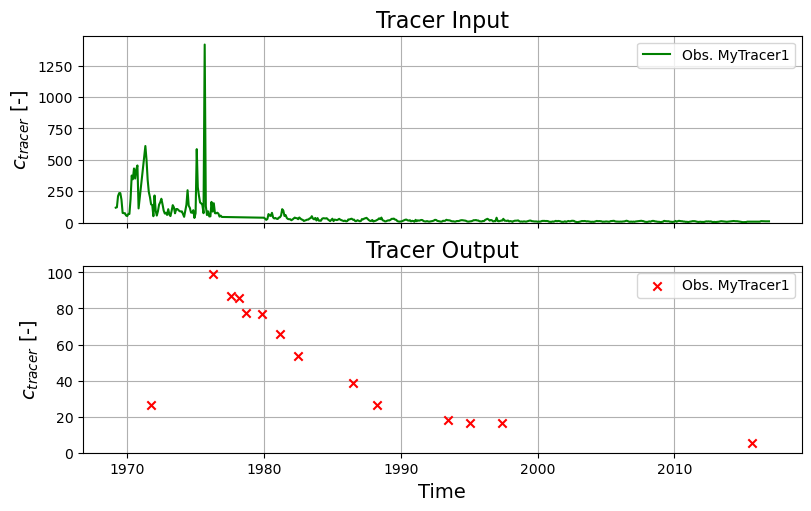

In [5]:
print('Here you can see your input data and the sample values')
sample_vis = sample.drop(sample[sample[3] == 0].index)
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(8, 5), constrained_layout=True, sharex=True)

ax1.plot(rain['Date'], rain[3], label='Obs. %s' % name_tracer_1, color='green')
ax1.plot(sample_vis['Date'], sample_vis[1], visible=False)
ax1.legend()
ax2.scatter(sample_vis['Date'], sample_vis[1], label='Obs. %s' % name_tracer_1, marker='x', zorder=5, c="red")
ax2.legend()
ax1.set_title("Tracer Input", fontsize=16)
ax1.set_ylabel('$c_{tracer}$ [-]', fontsize=14)
ax1.set_ylim(0)

ax2.set_title("Tracer Output", fontsize=16)
ax2.set_ylabel('$c_{tracer}$ [-]', fontsize=14)
ax2.set_xlabel('Time', fontsize=14)
ax2.set_ylim(0)
ax1.grid(zorder=0)
ax2.grid(zorder=0)

### Step 3: Model Setup

This is all done in the background...

In [6]:
# instantiate / initialize the parameterization object
Par()

# set initial run / model number
Par.n = 0

# set monthly step (i.e., decay constant is divided by 12 and mean TT is multiplied by 12)
Par.step = 0

# set option to NOT include the vadose zone (other option not yet implemented)
Par.SOILM = 0

# handle recharge according to Par.SOILM
if Par.SOILM == 0:
    print('The tracer concentration in recharge water is assumed to be equal to the concentration in precipitation water.')
    Cin = rain['weighted_c']
elif Par.SOILM == 1:
    pass
elif Par.SOILM == 2:
    pass

The tracer concentration in recharge water is assumed to be equal to the concentration in precipitation water.


### Step 4: Setting Model Parameters, Running the Model, and Plotting the Results

You will see two `     Run Interact     `-buttons below.

You have to **press the <u>upper button</u> to run the model** with the current parameter values.

You have to **press the <u>lower button</u> to plot the results** with the current plotting settings.

If you want to update anything (model parameters / plotting settings), you have to press the corresponding button for the changes to take effect!
___
___

In [7]:
print('Model type and parameter values:')
def setParameters(model, mean_tt, half_time, pd_, eta):
    if model == 'Piston Flow Model (MTT, HL)':
        Par.MODNUM = 1
    elif model == 'Exponential Model (MTT, HL)':
        Par.MODNUM = 2
    elif model == 'Dispersion Model (MTT, HL, PD)':
        Par.MODNUM = 3
    elif model == 'Linear Model (MTT, HL)':
        Par.MODNUM = 4
    elif model == 'Exponential - Piston Flow Model (MTT, HL, PD, E)':
        Par.MODNUM = 5
    Par.TT = mean_tt
    Par.Thalf_1 = half_time
    Par.PD = pd_
    Par.eta = eta
    
    """ run model """
    
    # define global variables for results and rsq
    global result
    global rsq

    # increase model (run) number by 1
    Par.n += 1
    
    # obtain the result
    result = Tracer(Par, Cin, rain)
    
    """ calculate fit metrics """
    
    ## use only available data
    
    # get the number of available observations
    orig_length = len(sample_vis[1])
    
    # make pandas Series (a time series) from model results
    results_series = pd.Series(data=result.result, index=rain['Date'])
    
    # get model results at dates which are available from the observations
    results_filtered = results_series.filter(items=sample_vis['Date'].dt.round("d"))
    
    # set the index of the observations Series to be the Date column
    sample_ = sample_vis.set_index(['Date'])
    
    # get observations at dates which are available from the (already reduced / truncated) model results
    sample_ = sample_.loc[results_filtered.index]
    
    # compute the correlation matrix for results and observations and select the cross-correlation
    corr = np.corrcoef(x=sample_.iloc[:, 1], y=results_filtered[:])[0, 1]
    # calculate the R^2
    rsq = corr ** 2.
    
    # calculate the MSE
    mse = np.sum((sample_.iloc[:, 1] - results_filtered.values) ** 2.) / len(results_filtered[:])
    
    # print the results
    print("The R^2 is {:1.3f} and the MSE is {:1.3f}, based on {} out of {} possible values".format(rsq, mse, len(results_filtered[:]), orig_length))
    
    ## use interpolation (interpolating results to observation dates)
    
    # make pandas Series (a time series) from model results
    results_series = pd.Series(data=result.result, index=rain['Date'])
    # force an index with daily frequency and interpolate
    # NOTE: this is necessary as ISOSIMpy only returns results at the first of each month
    #     but observations are available at other times / days so we need to have those observation
    #     dates in the index as well
    results_series = results_series.reindex(pd.date_range(start=results_series.index[0], end=results_series.index[-1], freq="D")).interpolate()
    # truncate the resulting series to start at the first observation date and to end at the
    #     last obervation date (at latest)
    results_series = results_series.truncate(before=sample_vis['Date'].iloc[0], after=sample_vis['Date'].iloc[-1])
    # drop remaining NaN values
    results_series = results_series.reindex(sample_vis['Date']).dropna()
    
    # set the index of the observation data to be the date column and truncate to the date-range
    #     of the results
    sample_ = sample_vis.set_index(['Date'])
    sample_ = sample_.truncate(before=results_series.index[0], after=results_series.index[-1])
    
    # compute the correlation matrix for results and observations and select the cross-correlation
    corr = np.corrcoef(x=sample_.iloc[:, 1].values, y=results_series.iloc[:].values)[0, 1]
    # calculate the R^2
    rsq = corr ** 2.
    
    # calculate the MSE
    mse = np.sum((sample_.iloc[:, 1].values - results_series.iloc[:].values) ** 2.) / len(results_series[:])
    
    # print the results
    print("The R^2 is {:1.3f} and the MSE is {:1.3f}, based on all values (linear interpolation)".format(rsq, mse))
    
    print("\n\nThe following line does not mean anything...")
    
    """ write log """
    
    with open(r'model_output/log.txt', 'a') as f:
        f.write(str(datetime.now()))
        f.write(';' + str(Par.n))
        f.write(';' + str(Par.MODNUM))
        f.write(';' + str(Par.TT))
        f.write(';' + str(Par.Thalf_1))
        f.write(';' + str(Par.PD))
        f.write(';' + str(Par.eta))
        f.write(';' + str("{:1.2f}".format(rsq)))
        f.write(';' + "    # date / time; run index; model type index; mean TT; half life; dispersion; exp. flow fraction")
        f.write('\n')
        
    """ write results """
    
    results_series.to_csv(r'model_output/results_{}.csv'.format(Par.n), sep=';')
    
    return result, rsq
    
def plot_results(min_year, max_year, min_conc, max_conc, log_scale):
    print('Here you can see your input data and the simulation results')
    sample_vis = sample.drop(sample[sample[3] == 0].index)
    fig3, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(8, 3), constrained_layout=True)
    ax3.plot(rain['Date'], rain[3], label='Input %s' % name_tracer_1, color='green')
    ax3.axvline(rain.iloc[np.argmax(rain[3]), 4], ls="--", c="black")
    ax3.legend()
    ax3.grid(zorder=0)
    ax3.tick_params(axis='x', which='minor', bottom=False)
    
    if log_scale == True:
        scale_ = "log"
    else:
        scale_ = "linear"
    
    ax3.set(title='Observed Tracer Source Concentration (Max. at {})'.format(rain.iloc[np.argmax(rain[3]), 4]),
            ylabel='$c$ [-]',
            xlabel='t',
            ylim=(min_conc, max_conc),
            xlim=(pd.to_datetime("{}-01-01".format(int(min_year))), pd.to_datetime("{}-01-01".format(int(max_year)))),
            yscale=scale_)
    
    fig4, ax4 = plt.subplots(nrows=1, ncols=1, figsize=(8, 3), constrained_layout=True)
    ax4.scatter(sample_vis['Date'], sample_vis[1], label='Output %s' % name_tracer_1, marker='x', zorder=5, c="red")
    ax4.plot(rain['Date'], result.result, label='Run Nr. {}, $R^2$={:1.2f}'.format(Par.n, rsq))
    ax4.axvline(rain.iloc[np.argmax(result.result), 4], ls="--", c="black")
    ax4.legend()
    ax4.grid(zorder=0)
    ax4.set(title='Observed and Simulated Tracer Output Conc. (Max. at {})'.format(rain.iloc[np.argmax(result.result), 4]),
            ylabel='$c$ [-]',
            xlabel='t',
            ylim=(min_conc, max_conc),
            xlim=(pd.to_datetime("{}-01-01".format(int(min_year))), pd.to_datetime("{}-12-31".format(int(max_year)))),
            yscale=scale_)
    
    # save figure
    # model mtt hl pd eta
    plt.savefig("model_run_{}_{}_{}_{}_{}.png".format(Par.MODNUM, Par.TT, Par.Thalf_1, Par.PD, Par.eta), dpi=400)
    
    return
    
interact_manual(setParameters,
    model = widgets.RadioButtons(options=['Piston Flow Model (MTT, HL)',
                                       'Exponential Model (MTT, HL)',
                                       'Dispersion Model (MTT, HL, PD)',
                                       'Linear Model (MTT, HL)',
                                       'Exponential - Piston Flow Model (MTT, HL, PD, E)'],
                              layout={'width': 'max-content'},
                              description='Modeltype:',
        style={'description_width': 'initial'}),
    mean_tt = widgets.BoundedIntText(value=10, min=1, max=100, step=1,
                                     description='Mean Travel Time (MTT) [a]:',
                                    style={'description_width': 'initial'}),
    half_time = widgets.BoundedFloatText(value=10, min=1, max=100, step=0.001,
                                         description='Half Life (HL) [a]:',
                                        style={'description_width': 'initial'}),
    pd_ = widgets.BoundedFloatText(value=0.1, min=0.01, max=1000, step=0.01,
                             description='Dispersion Parameter (PD) [-]:',
                                 style={'description_width': 'initial'}),
    eta = widgets.BoundedFloatText(value=0.5, min=0.01, max=1, step=0.01,
                             description='Exp. Flow Fraction (E) [-]:',
                                  style={'description_width': 'initial'}))

print("\n")

interact_manual(
    plot_results,
    min_year=widgets.BoundedIntText(
        value=1950,
        min=1950,
        max=2022,
        step=1,
        description="First Year to Show",
        style={'description_width': 'initial'}
    ),
    max_year=widgets.BoundedIntText(
        value=2023,
        min=1951,
        max=2023,
        step=1,
        description="Last Year to Show",
        style={'description_width': 'initial'}
    ),
    min_conc=widgets.BoundedFloatText(
        value=1e-1,
        min=1e-4,
        max=1e4,
        step=1e-4,
        description="Minimum Concentration to Show",
        style={'description_width': 'initial'}
    ),
    max_conc=widgets.BoundedFloatText(
        value=1e4,
        min=1e-4,
        max=1e4,
        step=1e-4,
        description="Maximum Concentration to Show",
        style={'description_width': 'initial'}
    ),
    log_scale=widgets.Dropdown(
        options=[('Logarithmic', True), ('Linear', False)],
        value=True,
        description='y-Axis Scale:',
    )
)

Model type and parameter values:


interactive(children=(RadioButtons(description='Modeltype:', layout=Layout(width='max-content'), options=('Pis…

interactive(children=(BoundedIntText(value=1950, description='First Year to Show', max=2022, min=1950, style=D…

<function __main__.plot_results(min_year, max_year, min_conc, max_conc, log_scale)>